##1. Exploratory Data Analysis (EDA)

#Load and inspect the data for basic properties (data types, missing values, duplicates).

In [89]:
import pandas as pd

df = pd.read_csv('sensor_data.csv')
df.head()

,timestamp,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
0,08-01-19 14:41,18.55,0.100,29.05,0.092,18.85,0.128
1,08-01-19 14:41,18.55,0.100,29.25,0.092,18.85,0.132
2,08-01-19 14:41,18.65,0.112,29.05,0.114,18.85,0.132
3,08-01-19 14:41,18.65,0.112,29.25,0.114,18.85,0.110
4,08-01-19 14:41,18.65,0.162,29.05,0.100,18.85,0.110


In [90]:
df.dtypes

,0
timestamp,object
x_axis_temperature,float64
x_axis_vibration,float64
y_axis_temperature,float64
y_axis_vibration,float64
z_axis_temperature,float64
z_axis_vibration,float64


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   timestamp           1048575 non-null  object 
 1   x_axis_temperature  851967 non-null   float64
 2   x_axis_vibration    851967 non-null   float64
 3   y_axis_temperature  851967 non-null   float64
 4   y_axis_vibration    851967 non-null   float64
 5   z_axis_temperature  851967 non-null   float64
 6   z_axis_vibration    851967 non-null   float64
dtypes: float64(6), object(1)
memory usage: 56.0+ MB


In [92]:
missing_values = df.isnull().sum()
print(missing_values)

timestamp                  0
x_axis_temperature    196608
x_axis_vibration      196608
y_axis_temperature    196608
y_axis_vibration      196608
z_axis_temperature    196608
z_axis_vibration      196608
dtype: int64


checking rows for duplicates would take too long and wouldn't generate an useful insight for the dataset

In [93]:
df.describe()

,x_axis_temperature,x_axis_vibration,y_axis_temperature,y_axis_vibration,z_axis_temperature,z_axis_vibration
count,851967.000000,851967.000000,851967.000000,851967.000000,851967.000000,851967.000000
mean,36.867385,1.014780,19.006035,0.139452,17.708302,0.116789
std,176.659111,7.432032,3.899055,0.254899,2.568081,0.026727
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
50%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
75%,17.650000,0.168000,18.550000,0.130000,18.150000,0.114000
max,1638.350000,65.535000,31.750000,23.732000,22.850000,1.160000


#Visualize the behavior of each sensor over time to identify trends, seasonality, or abrupt changes.

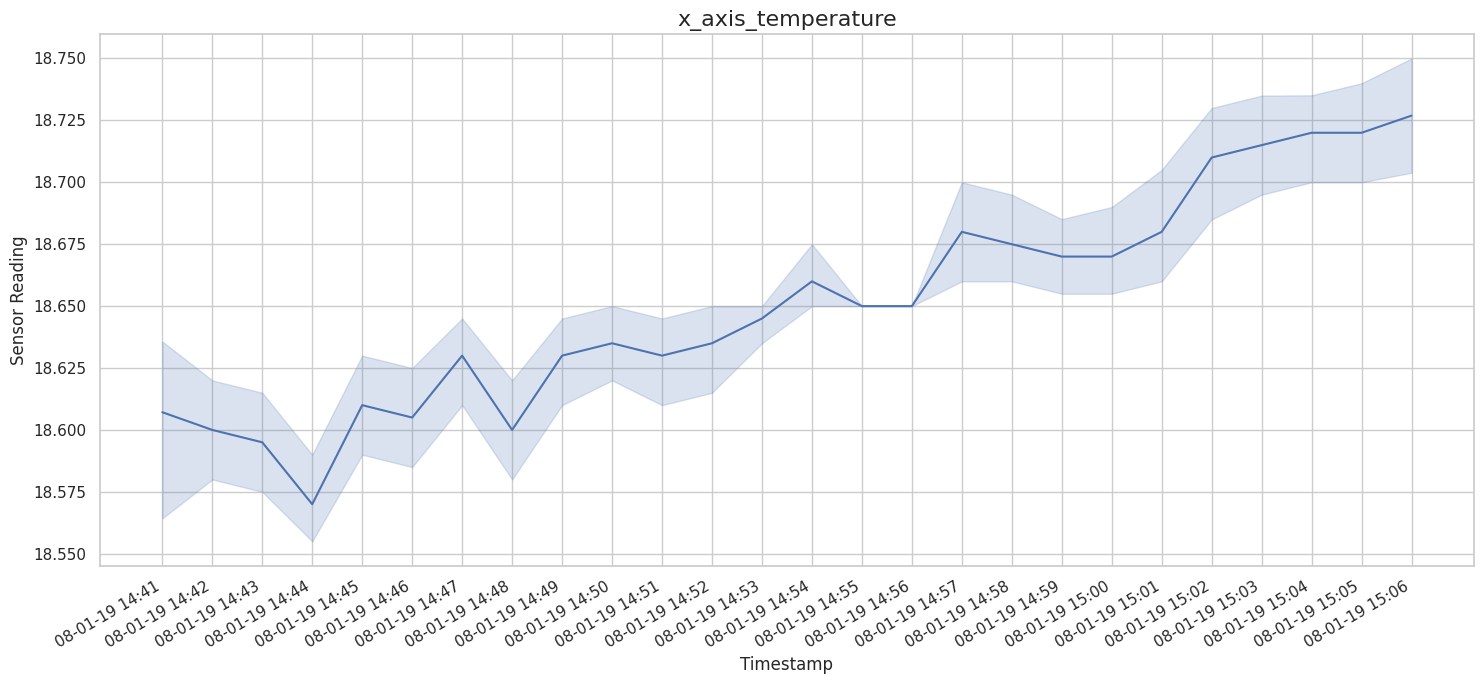

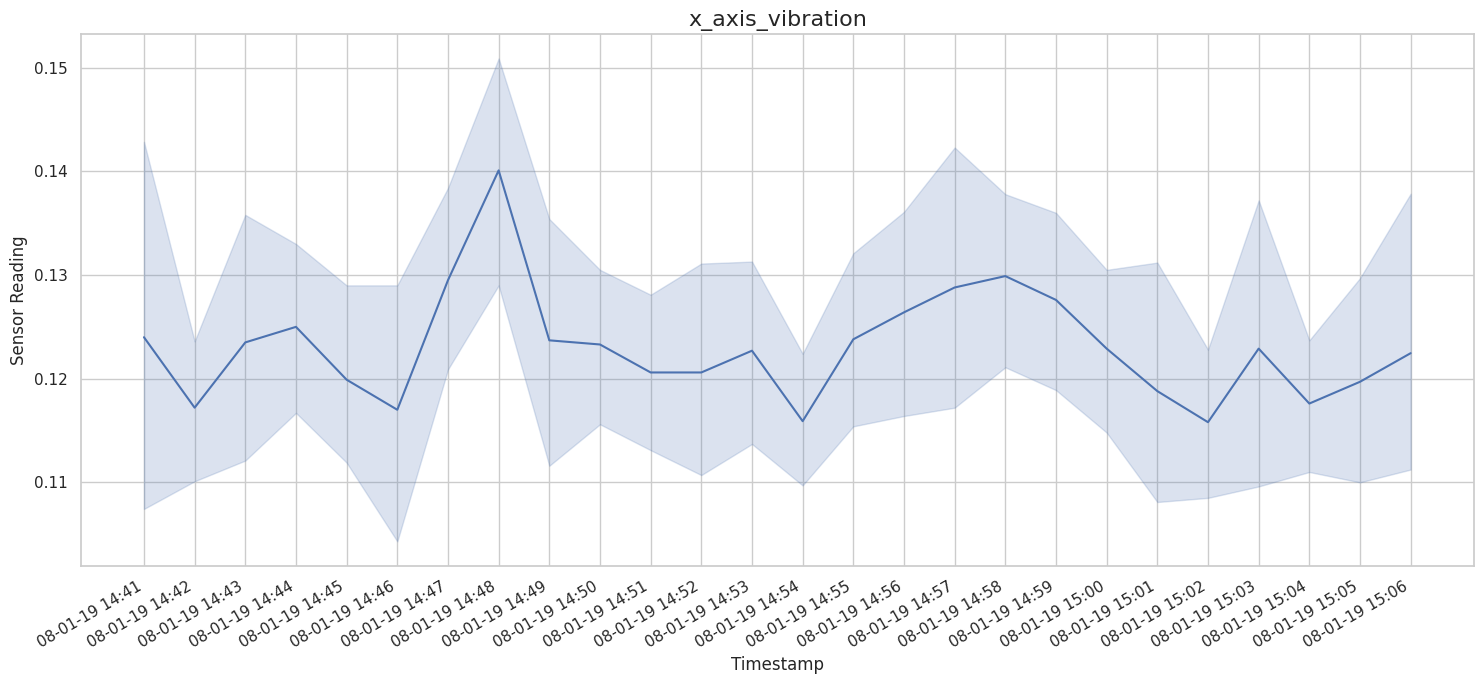

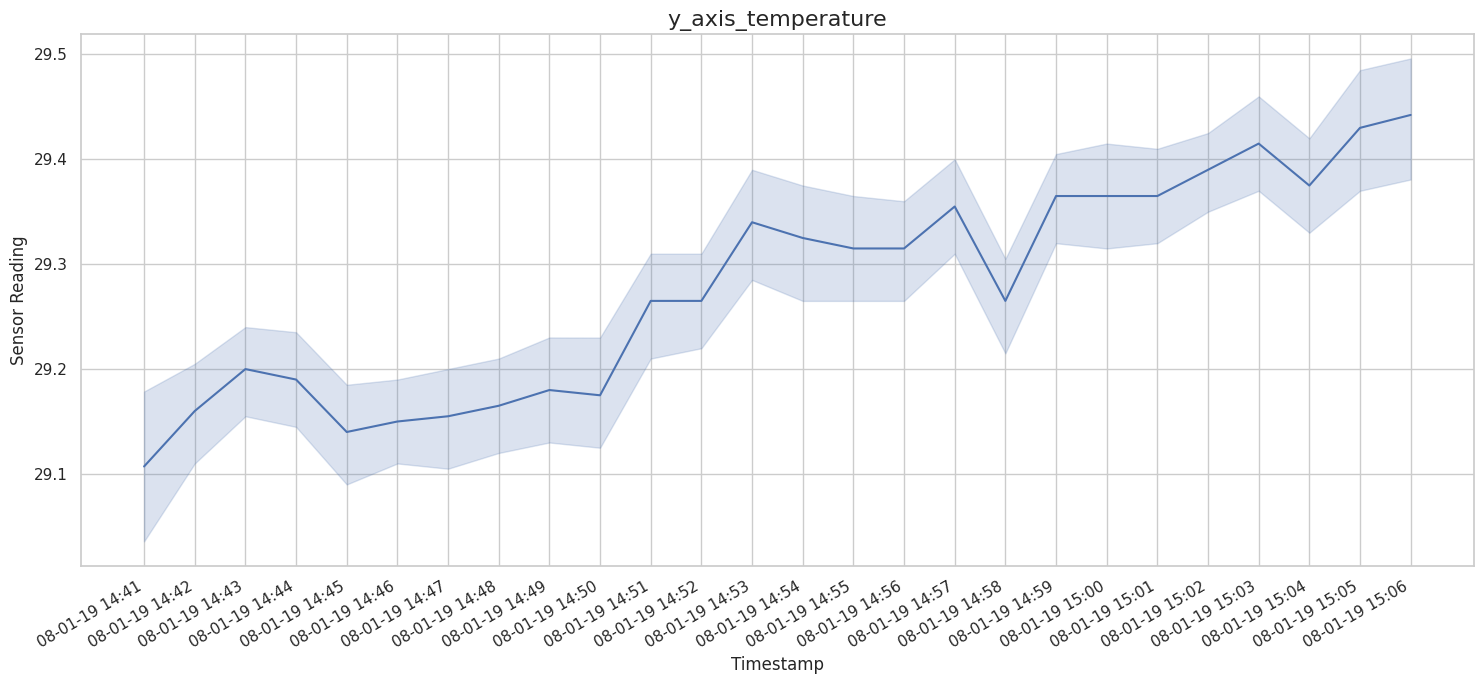

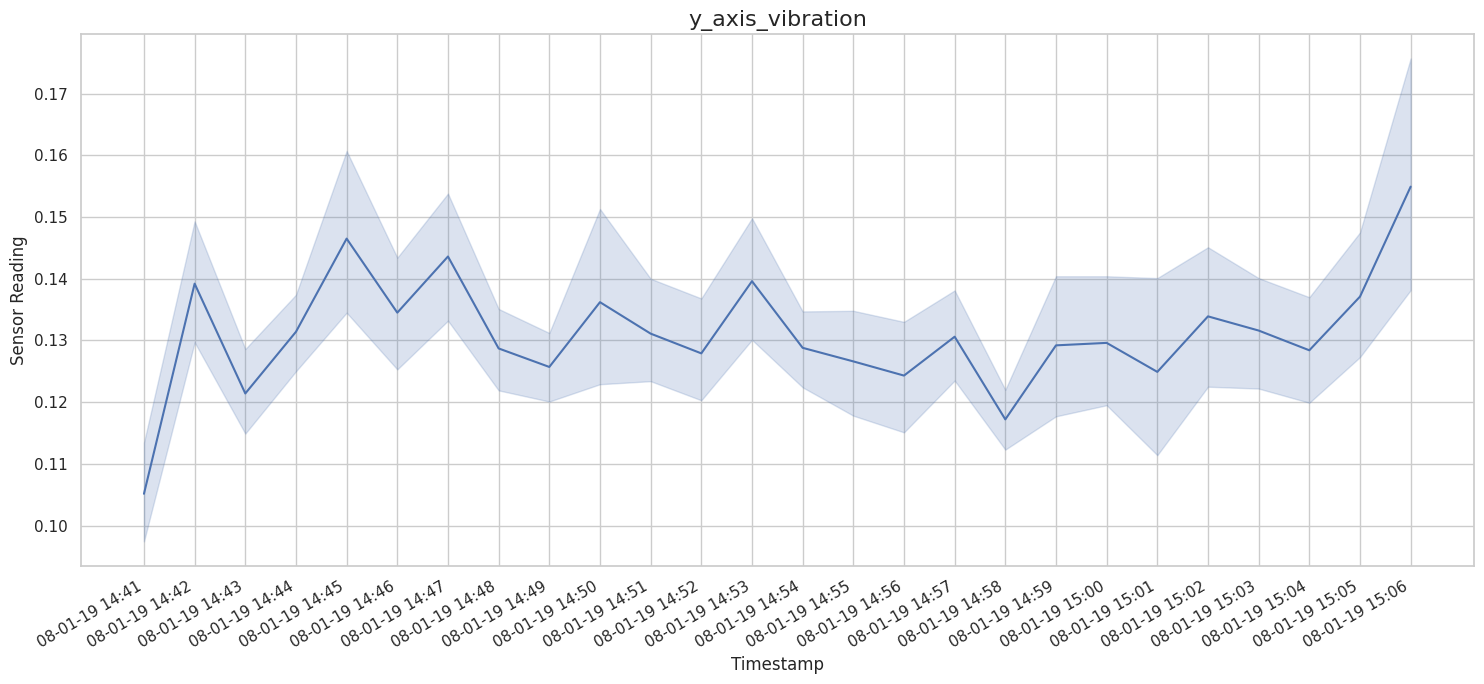

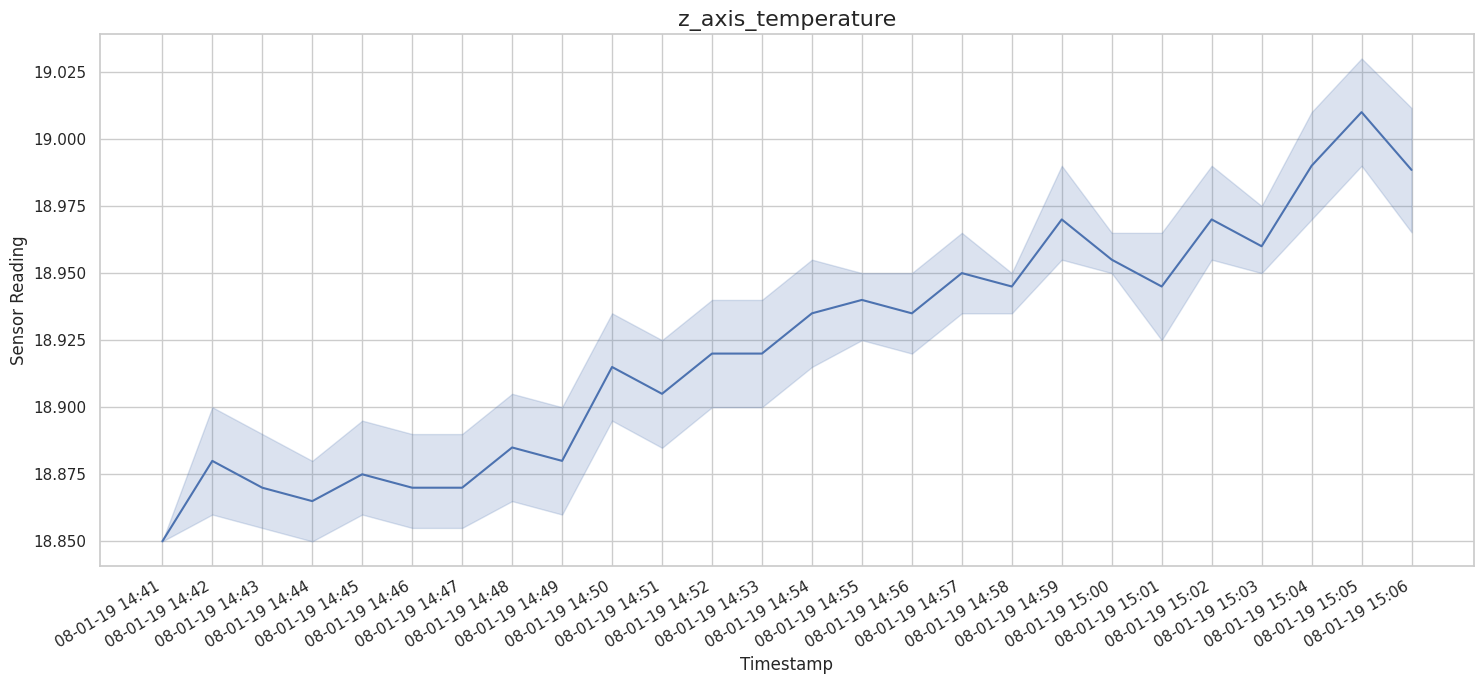

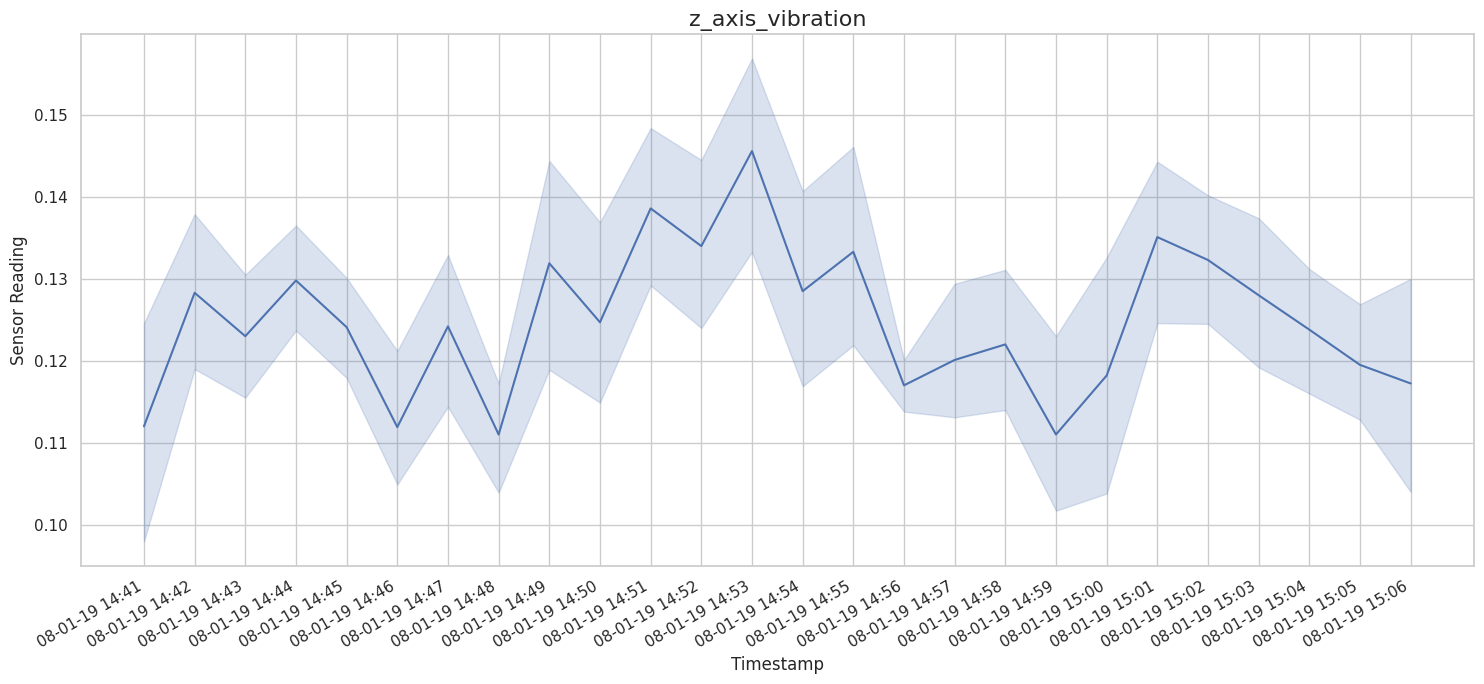

In [94]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_data(df):

    sensor_cols_to_plot = df.select_dtypes(include=np.number).columns.tolist()

    sns.set_theme(style="whitegrid")

    for sensor in sensor_cols_to_plot:
        # Create a new figure for each plot to keep them separate
        plt.figure(figsize=(15, 7))

        # Create the line plot
        ax = sns.lineplot(
            x='timestamp',
            y=sensor,
            data=df
        )

        # Set titles and labels
        ax.set_title(f'{sensor}', fontsize=16)
        ax.set_xlabel('Timestamp', fontsize=12)
        ax.set_ylabel('Sensor Reading', fontsize=12)

        plt.gcf().autofmt_xdate()

        plt.tight_layout()
        plt.show()


df = df.dropna()

plot_data(df[0:500])

#Analyze the distributions of sensor readings to understand their typical ranges and identify potential outliers.

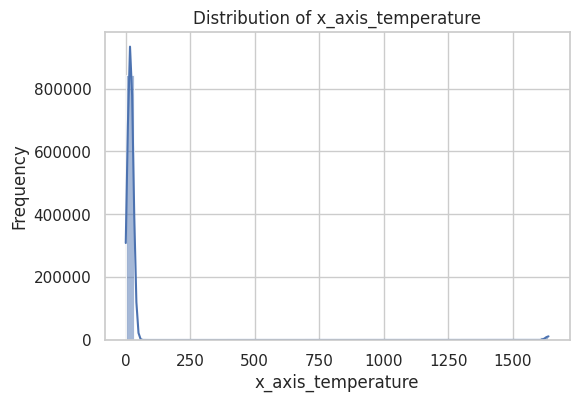

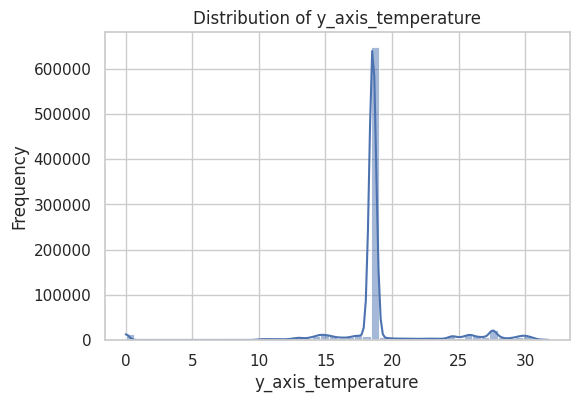

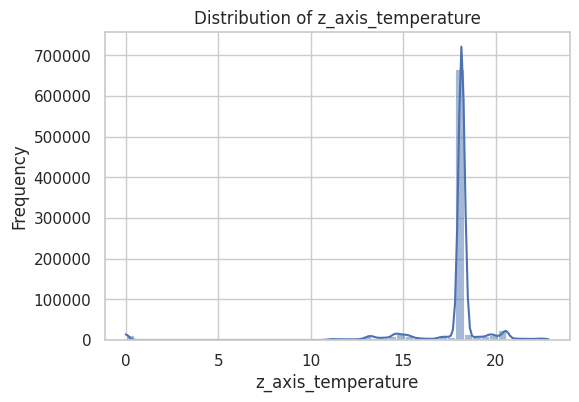

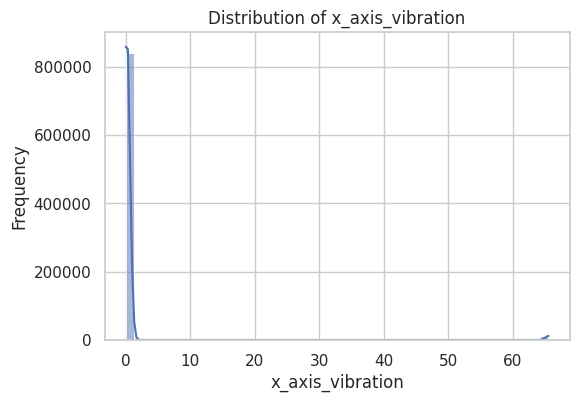

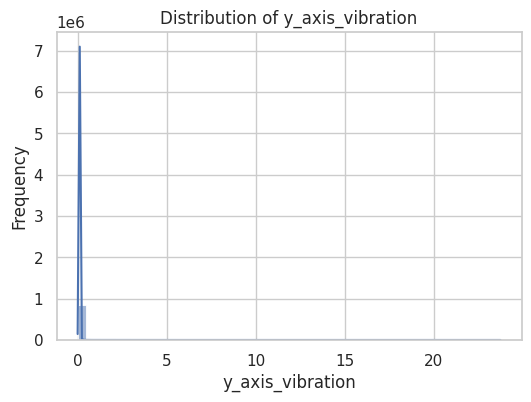

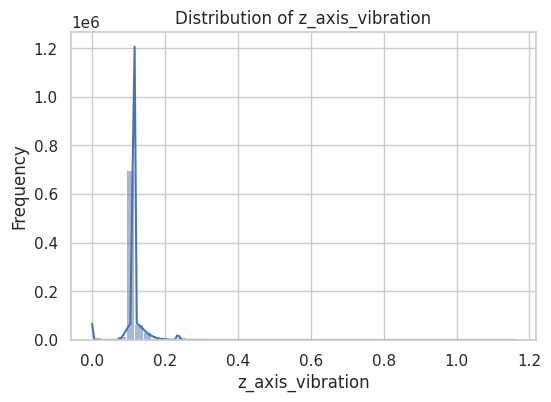

In [95]:
sensor_columns = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", 'x_axis_vibration', 'y_axis_vibration', 'z_axis_vibration']  # replace with your real sensor names

# Histograms
for col in sensor_columns:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], bins=50, kde=True)  # kde=True adds smooth density curve
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

outlier detection

In [96]:
from sklearn.ensemble import IsolationForest

# Sadece sensör kolonlarını seç
sensor_cols = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]
X = df[sensor_cols]

# Modeli tanımla
iso = IsolationForest(contamination=0.01, random_state=42, n_jobs=-1)
df["outlier"] = iso.fit_predict(X)

# outlier=-1 --> anormal, 1 --> normal
outliers = df[df["outlier"] == -1]
print("Outlier count:", len(outliers))


Outlier count: 2414


In [97]:
def show_stats(df, cols, label):
    print(f"\n--- {label} ---")
    print(df[cols].describe(percentiles=[0.01,0.05,0.95,0.99]))

sensor_cols = ["x_axis_temperature", "y_axis_temperature", "z_axis_temperature", "x_axis_vibration", "y_axis_vibration", "z_axis_vibration"]

# Outlier yokken
show_stats(df, sensor_cols, "Tüm veri")

# Outlier'lar çıkarıldıktan sonra
clean_df = df[df["outlier"] == 1]
show_stats(clean_df, sensor_cols, "Outlierlar çıkarıldıktan sonra")



--- Tüm veri ---
       x_axis_temperature  y_axis_temperature  z_axis_temperature  \
count       851967.000000       851967.000000       851967.000000   
mean            36.867385           19.006035           17.708302   
std            176.659111            3.899055            2.568081   
min              0.000000            0.000000            0.000000   
1%               0.000000            0.000000            0.000000   
5%              14.050000           14.750000           14.350000   
50%             17.650000           18.550000           18.150000   
95%             21.650000           27.550000           19.950000   
99%           1638.350000           30.050000           21.550000   
max           1638.350000           31.750000           22.850000   

       x_axis_vibration  y_axis_vibration  z_axis_vibration  
count     851967.000000     851967.000000     851967.000000  
mean           1.014780          0.139452          0.116789  
std            7.432032          0.2

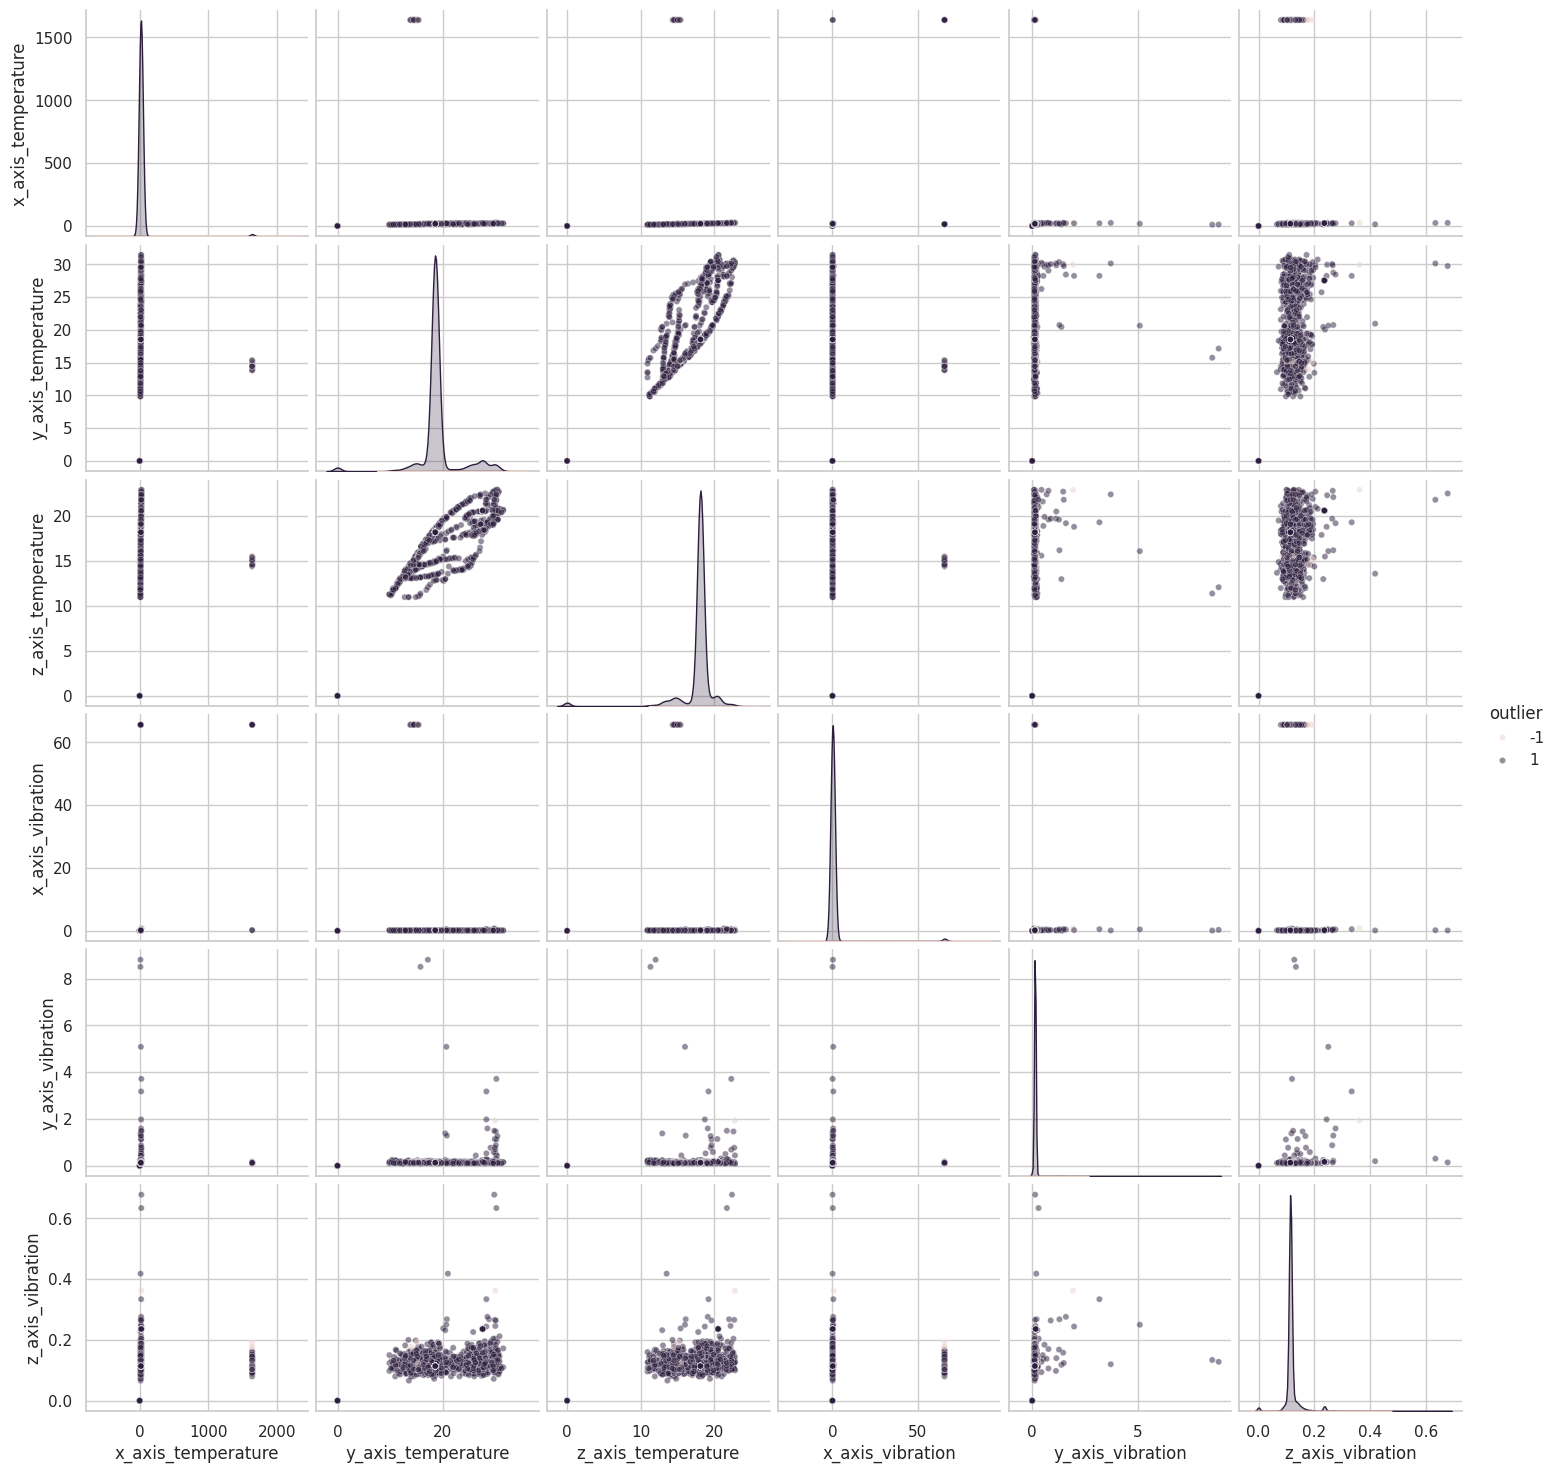

In [98]:
sns.pairplot(
    df.sample(5000),  # büyük veri olduğu için örnekle
    vars=["x_axis_temperature","y_axis_temperature","z_axis_temperature",
          "x_axis_vibration","y_axis_vibration","z_axis_vibration"],
    hue="outlier",
    plot_kws={"alpha":0.5, "s":20}
)
plt.show()


##2. Data Preprocessing

#Ensure the timestamp column is converted to the correct datetime format.

In [99]:
df['timestamp'] = pd.to_datetime(df['timestamp']) # coerce ve format
df['timestamp'].head()

/tmp/ipython-input-2606475919.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']) # coerce ve format


,timestamp
0,2019-08-01 14:41:00
1,2019-08-01 14:41:00
2,2019-08-01 14:41:00
3,2019-08-01 14:41:00
4,2019-08-01 14:41:00


#Consider the trade-offs of resampling the data to a lower frequency (e.g., 15-second, 1-minute averages or 1-hour averages). Justify your choice based on whether it reduces noise without losing critical information.

In [113]:
if 'timestamp' in df.columns: #kod ikinci kez çalıştığında  hata almamak için
    df = df.set_index('timestamp')
minutely_resampled_data = df.resample("M").mean()

df.head()
num_rows = len(df.index)
print(num_rows)

size:  851967
851967


/tmp/ipython-input-3408701940.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  minutely_resampled_data = df.resample("M").mean()


#Apply appropriate scaling to the sensor data. Research different scaling techniques (e.g., MinMaxScaler, StandardScaler) and determine which is most suitable for the models you plan to test.

##3. Feature Engineering


##4. Unsupervised Anomaly Detection

##5. Remaining Useful Life (RUL) Modeling and Training

##6. Hyperparameter Tuning

##7. Test and Evaluation